<a href="https://colab.research.google.com/github/VstCodes/Social_Engineering_Email_Detection_System/blob/main/security_proje_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SOCIAL ENGINEERING EMAIL DETECTION SYSTEM**

CENG3544 - Computer and Network Security Final Project
<br>Instructor : Enis Karaarslan
<br>Student : Vuslat Sülbiye Türk

# DATA PREPROCESSING

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Define the file path for the Excel dataset
file_path = "/content/security_final_project_training_data.xlsx"

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Step 1: Drop rows where the 'text' field is missing (to avoid processing empty emails)
df_clean = df.dropna(subset=['text']).copy()

# Step 2: Convert the 'category' string into a list of individual labels
# For example, "urgency,impersonation" becomes ["urgency", "impersonation"]
df_clean['label_list'] = df_clean['category'].apply(lambda x: [label.strip() for label in x.split(',')])

# Step 3: Transform the multi-label data into binary format (multi-hot encoding)
# Each unique label gets its own column, with 1 if present and 0 otherwise
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(df_clean['label_list'])

# Create a new DataFrame with binary label columns (multi-hot encoded labels)
df_labels = pd.DataFrame(label_matrix, columns=mlb.classes_)

# Step 4: Combine the cleaned text data with the binary label columns
# Reset the index to ensure alignment during concatenation
df_clean = df_clean.reset_index(drop=True)
df_processed = pd.concat([df_clean[['text']], df_labels], axis=1)

# Display the first 5 rows of the preprocessed dataset for inspection
df_processed.head()

,text,authority,impersonation,persuasion,safe email,urgency
0,Free entry in 2 a wkly comp to win FA Cup fina...,0,0,1,0,0
1,FreeMsg Hey there darling it's been 3 week's n...,0,0,1,0,1
2,WINNER!! As a valued network customer you have...,0,0,1,0,0
3,Had your mobile 11 months or more? U R entitle...,0,0,1,0,0
4,"SIX chances to win CASH! From 100 to 20,000 po...",0,0,1,0,0


<Axes: title={'center': 'Label Distribution'}, xlabel='label_list'>

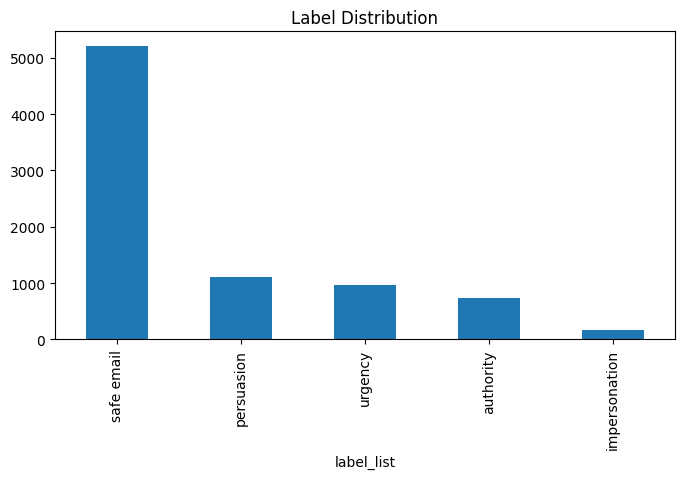

In [ ]:
import pandas as pd

# Explode the 'label_list' column to create one row per label (flatten the lists)
# Then count the occurrences of each label to see their frequency in the dataset
# Finally, plot a bar chart showing the distribution of labels
df_clean['label_list'].explode().value_counts().plot(
    kind='bar',                 # Use a bar chart
    title='Label Distribution', # Set the title of the plot
    figsize=(8,4)               # Set the size of the figure
)

In [ ]:
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 5: Define a function to clean the email text data
def clean_text(text):
    # Ensure the input is a string to avoid errors
    if not isinstance(text, str):
        return ""  # Return empty string if input is not valid text

    # Convert all characters to lowercase for uniformity
    text = text.lower()
    # Remove URLs starting with http, https, or www using regex
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation marks using string translation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove all numbers (digits) from the text
    text = re.sub(r'\d+', '', text)
    # Replace multiple spaces or tabs with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to each row in the 'text' column and create a new 'clean_text' column
df_processed['clean_text'] = df_processed['text'].apply(clean_text)

# Step 6: Convert the cleaned text data into numerical features using TF-IDF vectorization
# Limit the vocabulary size to 5000 most important words (can be adjusted)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_processed['clean_text'])  # Fit to data and transform

# Step 7: Extract the target labels (multi-label binary columns) for classification
y = df_processed[['authority', 'impersonation', 'persuasion', 'safe email', 'urgency']]

# Step 8: Split the dataset into training and testing sets
# 80% of data is used for training, 20% for testing, with a fixed random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Print the shapes of the splits to verify correct sizes
print("X_train shape:", X_train.shape)  # Number of training samples and features
print("y_train shape:", y_train.shape)  # Number of training samples and labels
print("X_test shape:", X_test.shape)    # Number of test samples and features
print("y_test shape:", y_test.shape)    # Number of test samples and labels

X_train shape: (6124, 5000)
y_train shape: (6124, 5)
X_test shape: (1531, 5000)
y_test shape: (1531, 5)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Get the raw text data from the DataFrame and ensure all entries are strings
X_raw = df_processed['text'].astype(str)

# Initialize the TF-IDF vectorizer with specific parameters:
# - stop_words='english' removes common English stop words (e.g., "the", "and")
# - max_df=0.95 ignores words that appear in more than 95% of the documents (too common)
# - min_df=2 ignores words that appear in fewer than 2 documents (too rare)
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

# Fit the vectorizer to the text data and transform it into TF-IDF features
X_tfidf = tfidf.fit_transform(X_raw)

In [ ]:
# Select only the relevant label columns from the processed DataFrame to form the target variable y
# These columns represent the multi-label classes for classification
y = df_processed[['authority', 'impersonation', 'persuasion', 'safe email', 'urgency']]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets:
# 80% of the data is used for training, 20% for testing
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 9: Define a multi-label classification model using One-vs-Rest strategy
# Logistic Regression is used as the base classifier
# class_weight='balanced' helps to handle class imbalance by adjusting weights inversely proportional to class frequencies
model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))

# Step 10: Train the model on the training data
model.fit(X_train, y_train)

# Step 11: Predict labels for the test data
y_pred = model.predict(X_test)

# Step 12: Print a detailed classification report including precision, recall, f1-score for each label
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=y.columns))

# Optional: Calculate and print accuracy separately for each label to understand per-label performance
for idx, col in enumerate(y.columns):
    acc = accuracy_score(y_test[col], y_pred[:, idx])
    print(f"Accuracy for {col}: {acc:.2f}")

Classification Report:

               precision    recall  f1-score   support

    authority       0.80      0.94      0.87       159
impersonation       0.53      1.00      0.69        33
   persuasion       0.86      0.97      0.91       229
   safe email       0.98      0.99      0.98      1009
      urgency       0.80      0.92      0.86       219

    micro avg       0.91      0.97      0.94      1649
    macro avg       0.80      0.96      0.86      1649
 weighted avg       0.92      0.97      0.94      1649
  samples avg       0.94      0.97      0.95      1649

Accuracy for authority: 0.97
Accuracy for impersonation: 0.98
Accuracy for persuasion: 0.97
Accuracy for safe email: 0.98
Accuracy for urgency: 0.96


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-88-1656226517>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1, palette="viridis")


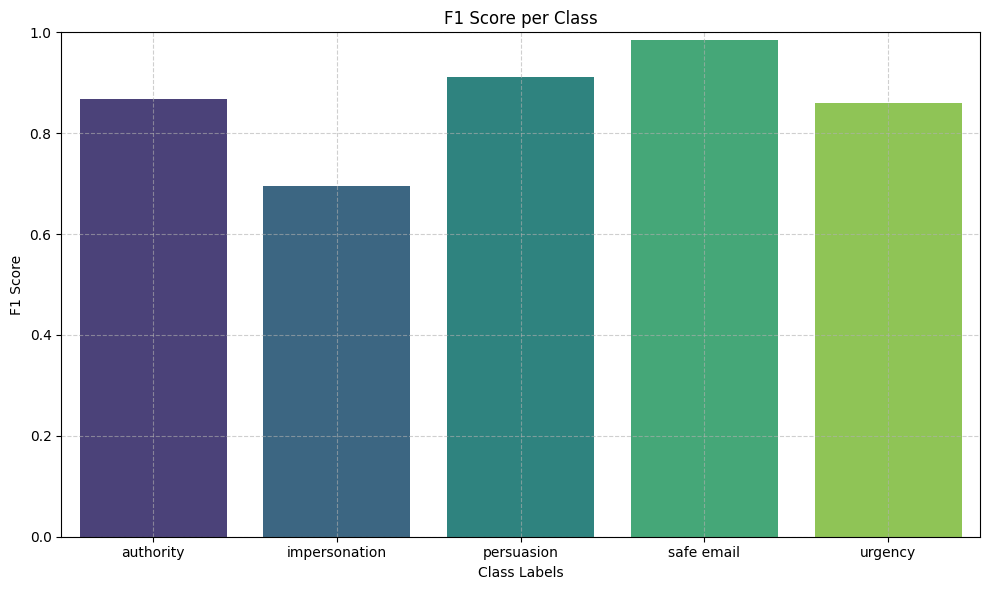

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 13: Calculate precision, recall, and F1-score for each label separately
# average=None returns the metric for each class/label individually
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Get the list of label names (column names)
labels = y.columns

# Step 14: Visualize the F1-score for each class using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=f1, palette="viridis")
plt.title("F1 Score per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)               # Set y-axis limits between 0 and 1
plt.xlabel("Class Labels")
plt.grid(True, linestyle="--", alpha=0.6)  # Add a light grid for readability
plt.tight_layout()           # Adjust plot layout to prevent overlap
plt.show()

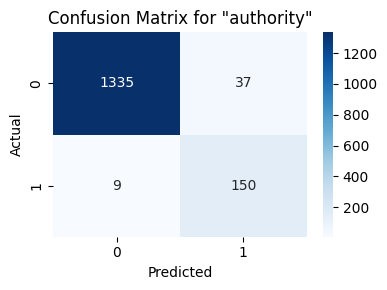

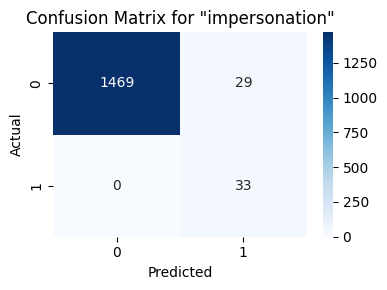

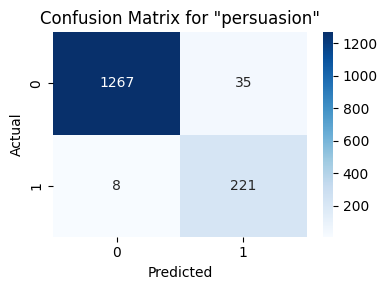

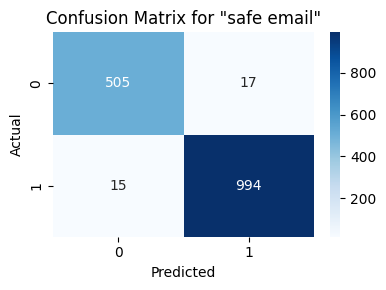

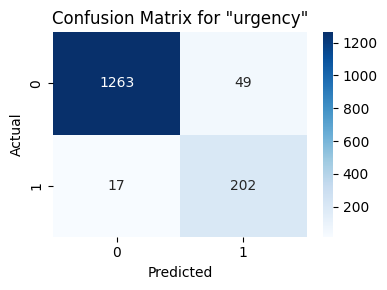

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Step 15: For each label, compute and plot its confusion matrix
for idx, label in enumerate(labels):
    # Compute confusion matrix comparing true vs predicted labels for the current class
    cm = confusion_matrix(y_test[label], y_pred[:, idx])

    # Create a new figure for each confusion matrix
    plt.figure(figsize=(4, 3))

    # Plot the confusion matrix as a heatmap with annotation
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Set plot titles and axis labels
    plt.title(f'Confusion Matrix for "{label}"')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Adjust layout to prevent overlapping elements
    plt.tight_layout()

    # Display the plot
    plt.show()

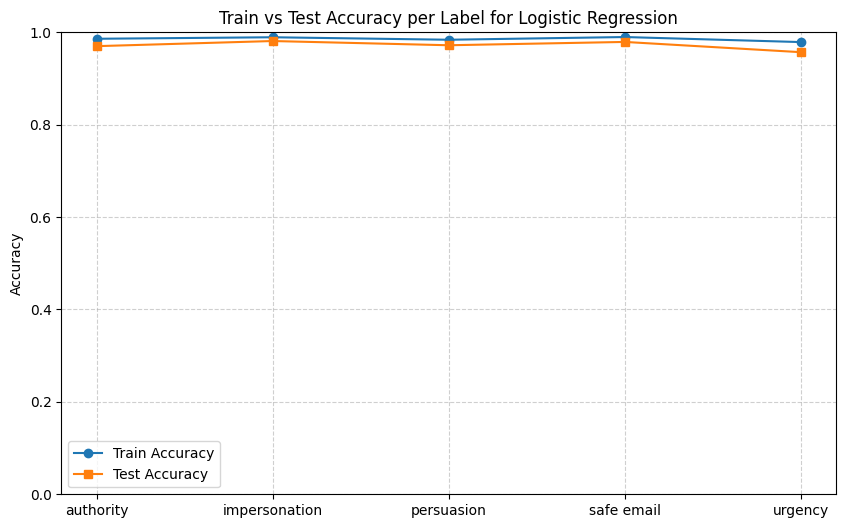

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Define a function to plot training and testing accuracy per label for a given model
def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    # Predict labels on the training set
    y_train_pred = model.predict(X_train)
    # Predict labels on the testing set
    y_test_pred = model.predict(X_test)

    # Get the list of label names
    labels = y.columns
    # Lists to store accuracy scores per label
    train_acc = []
    test_acc = []

    # Calculate accuracy for each label on both train and test data
    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    # Create an array for x-axis positions (one per label)
    x = np.arange(len(labels))

    # Plot the accuracy lines
    plt.figure(figsize=(10,6))
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    # Set x-axis labels to the label names
    plt.xticks(x, labels)
    plt.ylim(0,1)                     # Accuracy ranges from 0 to 1
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)  # Light grid for readability
    plt.legend()
    plt.show()

# Example usage of the function for Logistic Regression model
plot_accuracy_line(model, X_train, y_train, X_test, y_test, "Logistic Regression")

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Define a scorer using micro-averaged F1-score, which is suitable for multi-label classification
f1_scorer = make_scorer(f1_score, average='micro')

# Initialize the model using One-vs-Rest strategy with Logistic Regression as the base classifier
model_logistic = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Perform 5-fold cross-validation on the entire dataset using the defined F1 scorer
scores = cross_val_score(model_logistic, X, y, cv=5, scoring=f1_scorer)

# Print the F1 scores for each fold
print("Cross-Validation F1 Scores:", scores)
# Print the mean F1 score across all folds
print("F1 Score:", scores)


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(


Cross-Validation F1 Scores: [0.05088757 0.9292998  0.99901929 0.99869281 0.91346825]
F1 Score: [0.05088757 0.9292998  0.99901929 0.99869281 0.91346825]


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-92-3238762837>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_f1_scores.index, y=label_f1_scores.values, palette="coolwarm")


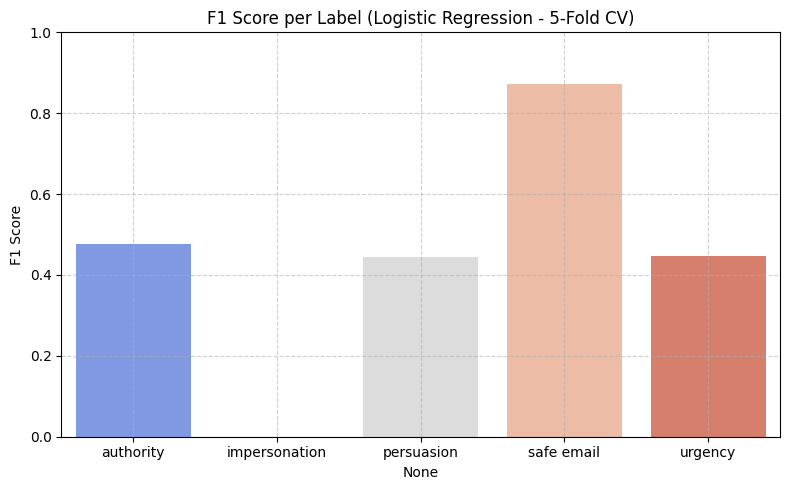

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import pandas as pd

# Define the model using One-vs-Rest strategy with Logistic Regression
model_logistic = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Obtain cross-validated predictions using 5-fold cross-validation
y_pred_cv = cross_val_predict(model_logistic, X, y, cv=5)

# Generate a classification report with precision, recall, and F1-score for each label
# output_dict=True returns the report as a dictionary for easier processing
report = classification_report(y, y_pred_cv, target_names=y.columns, output_dict=True)

# Convert the classification report dictionary into a pandas DataFrame and transpose it
report_df = pd.DataFrame(report).transpose()

# Filter the DataFrame to include only rows corresponding to the actual labels (exclude averages and accuracy)
label_f1_scores = report_df.loc[y.columns, "f1-score"]

# Plot a bar chart of the F1 scores for each label
plt.figure(figsize=(8, 5))
sns.barplot(x=label_f1_scores.index, y=label_f1_scores.values, palette="coolwarm")
plt.title("F1 Score per Label (Logistic Regression - 5-Fold CV)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)                      # Limit y-axis between 0 and 1 for F1 scores
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid for readability
plt.tight_layout()                 # Adjust layout to prevent overlap
plt.show()

# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the model using One-vs-Rest strategy with Random Forest as the base classifier
rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

# Train the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Predict labels on the test set
y_pred_rf = rf_model.predict(X_test)

# Print a detailed classification report (precision, recall, f1-score) for each label
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=y.columns))

# Calculate and print accuracy separately for each label to evaluate per-label performance
for idx, col in enumerate(y.columns):
    acc = accuracy_score(y_test[col], y_pred_rf[:, idx])
    print(f"Accuracy for {col}: {acc:.2f}")

Random Forest Classification Report:

               precision    recall  f1-score   support

    authority       0.98      0.86      0.92       159
impersonation       1.00      0.55      0.71        33
   persuasion       0.99      0.93      0.96       229
   safe email       0.98      0.99      0.99      1009
      urgency       0.99      0.83      0.91       219

    micro avg       0.98      0.94      0.96      1649
    macro avg       0.99      0.83      0.90      1649
 weighted avg       0.98      0.94      0.96      1649
  samples avg       0.97      0.96      0.96      1649

Accuracy for authority: 0.98
Accuracy for impersonation: 0.99
Accuracy for persuasion: 0.99
Accuracy for safe email: 0.98
Accuracy for urgency: 0.98


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-94-1873718513>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_rf, palette="viridis")


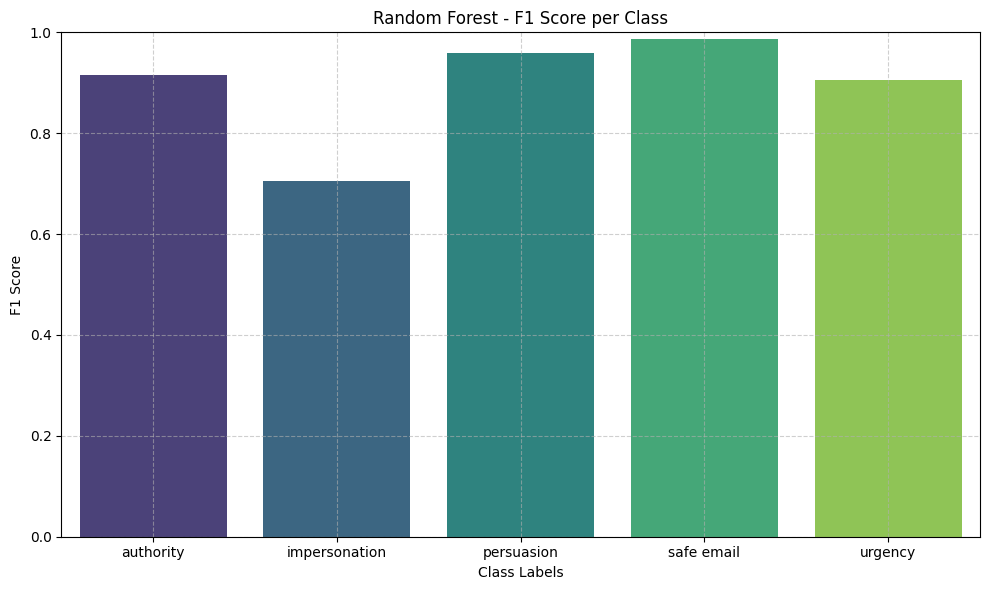

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test and y_pred_rf are already defined for Random Forest predictions and true labels

# Calculate evaluation metrics per label: precision, recall, and F1-score
precision_rf = precision_score(y_test, y_pred_rf, average=None)
recall_rf = recall_score(y_test, y_pred_rf, average=None)
f1_rf = f1_score(y_test, y_pred_rf, average=None)

# Get label names
labels = y.columns

# Visualize the F1 scores for each class using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=f1_rf, palette="viridis")
plt.title("Random Forest - F1 Score per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)               # Set y-axis limits between 0 and 1
plt.xlabel("Class Labels")
plt.grid(True, linestyle="--", alpha=0.6)  # Add grid for readability
plt.tight_layout()           # Adjust layout to avoid overlap
plt.show()

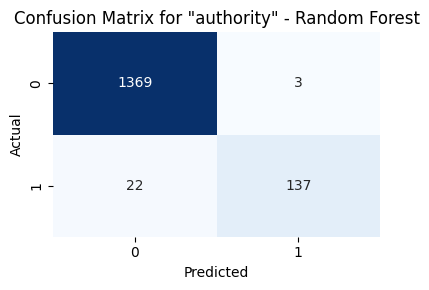

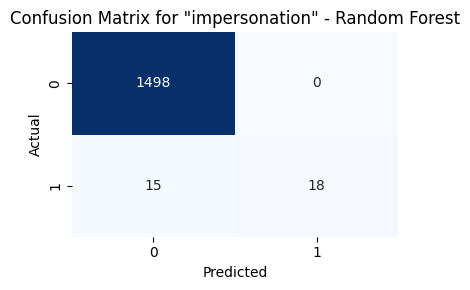

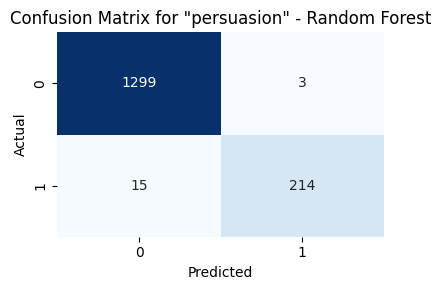

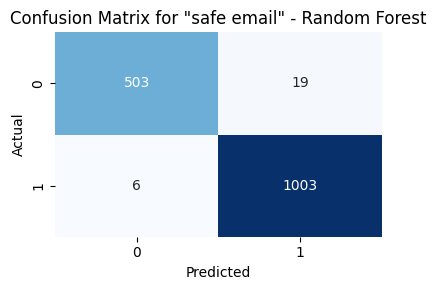

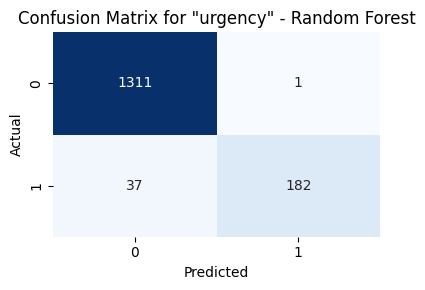

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 'labels' is already defined as y.columns (the class labels)
for idx, label in enumerate(labels):
    # Compute the confusion matrix for each label
    cm = confusion_matrix(y_test[label], y_pred_rf[:, idx])

    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # Annotate cells with numbers, no color bar
    plt.title(f'Confusion Matrix for "{label}" - Random Forest')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

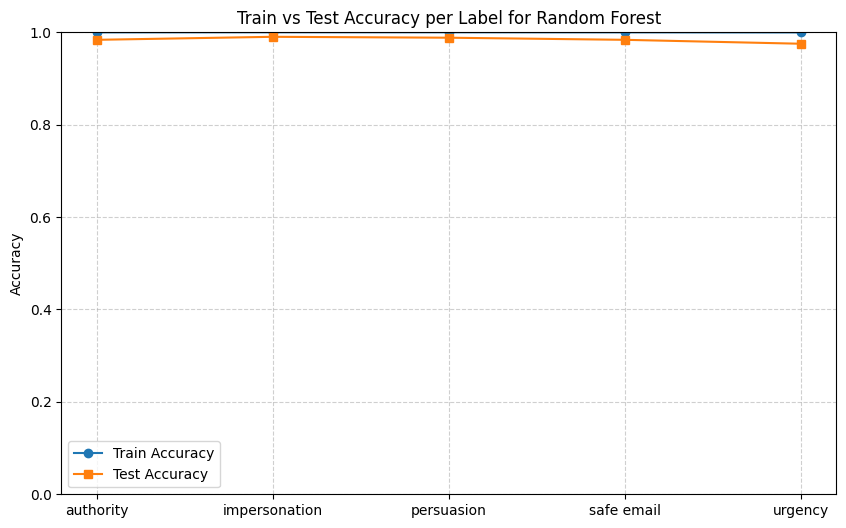

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Function to plot train vs test accuracy per label for a given model
def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    # Predict labels on the training set
    y_train_pred = model.predict(X_train)
    # Predict labels on the test set
    y_test_pred = model.predict(X_test)

    # Get the list of label names
    labels = y.columns
    train_acc = []
    test_acc = []

    # Calculate accuracy for each label separately for train and test sets
    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    # Create x-axis indices for labels
    x = np.arange(len(labels))

    # Plot accuracies with different markers for train and test
    plt.figure(figsize=(10,6))
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    # Set x-axis ticks and labels
    plt.xticks(x, labels)
    plt.ylim(0,1)             # Accuracy ranges between 0 and 1
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid for readability
    plt.legend()
    plt.show()

# Call the function to plot accuracies for Random Forest model
plot_accuracy_line(rf_model, X_train, y_train, X_test, y_test, "Random Forest")

# LINEAR SVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the model using OneVsRest strategy with LinearSVC
svc_model = OneVsRestClassifier(LinearSVC(max_iter=10000, random_state=42))

# Train the model on the training data
svc_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_svc = svc_model.predict(X_test)

# Print the classification report showing precision, recall, f1-score per label
print("Linear SVC Classification Report:\n")
print(classification_report(y_test, y_pred_svc, target_names=y.columns))

# Print accuracy score for each label individually
for idx, col in enumerate(y.columns):
    acc = accuracy_score(y_test[col], y_pred_svc[:, idx])
    print(f"Accuracy for {col}: {acc:.2f}")

Linear SVC Classification Report:

               precision    recall  f1-score   support

    authority       0.96      0.91      0.93       159
impersonation       0.88      0.91      0.90        33
   persuasion       0.95      0.97      0.96       229
   safe email       0.99      0.99      0.99      1009
      urgency       0.95      0.86      0.90       219

    micro avg       0.97      0.96      0.97      1649
    macro avg       0.95      0.93      0.94      1649
 weighted avg       0.97      0.96      0.97      1649
  samples avg       0.97      0.97      0.97      1649

Accuracy for authority: 0.99
Accuracy for impersonation: 1.00
Accuracy for persuasion: 0.99
Accuracy for safe email: 0.99
Accuracy for urgency: 0.97


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-98-691658920>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores_svc, palette="viridis")


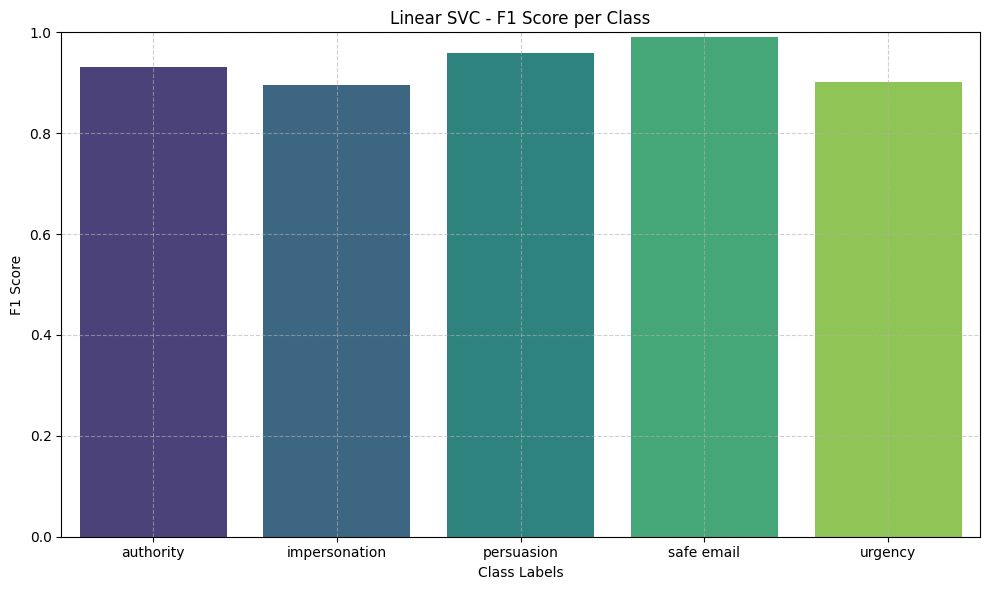

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Calculate F1 scores for each class label
f1_scores_svc = f1_score(y_test, y_pred_svc, average=None)

# Get the list of class labels
labels = y.columns

# Plot F1 scores using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=f1_scores_svc, palette="viridis")
plt.title("Linear SVC - F1 Score per Class")
plt.ylabel("F1 Score")
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.xlabel("Class Labels")
plt.grid(True, linestyle="--", alpha=0.6)  # Add grid for readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

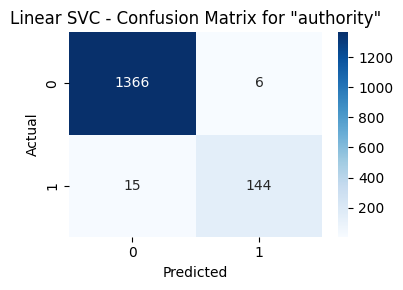

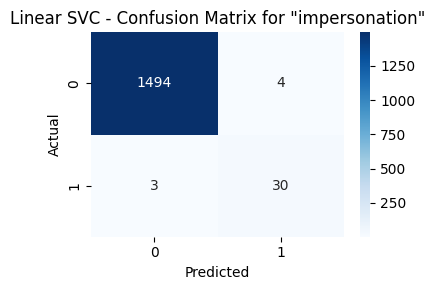

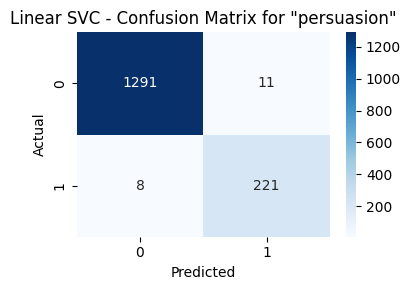

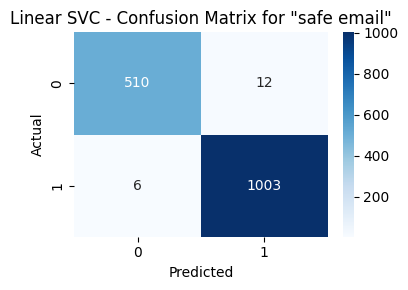

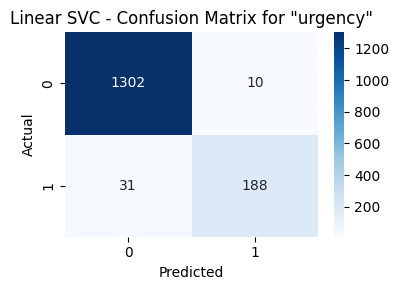

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of label names
labels = y.columns

# Loop over each label to compute and plot its confusion matrix
for idx, label in enumerate(labels):
    # Compute confusion matrix for the current label
    cm = confusion_matrix(y_test[label], y_pred_svc[:, idx])

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Linear SVC - Confusion Matrix for "{label}"')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

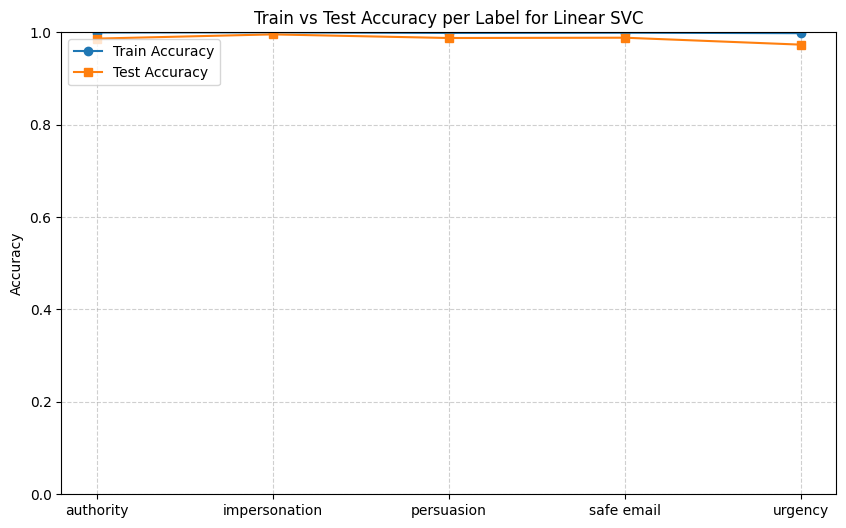

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    # Predict on training data
    y_train_pred = model.predict(X_train)
    # Predict on test data
    y_test_pred = model.predict(X_test)

    labels = y.columns
    train_acc = []
    test_acc = []

    # Calculate accuracy for each label in both train and test sets
    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))  # X-axis positions for labels

    # Plot accuracy for train and test sets per label
    plt.figure(figsize=(10,6))
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    plt.xticks(x, labels)  # Set label names on x-axis
    plt.ylim(0,1)          # Set y-axis limits between 0 and 1
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid lines for readability
    plt.legend()
    plt.show()

# Call the function to plot accuracy lines for Linear SVC model
plot_accuracy_line(svc_model, X_train, y_train, X_test, y_test, "Linear SVC")

# MULTINOMIAL NAIVE BAYES

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the Multinomial Naive Bayes model wrapped in OneVsRest for multi-label classification
nb_model = OneVsRestClassifier(MultinomialNB())

# Train the model on training data
nb_model.fit(X_train, y_train)

# Predict on the test data
y_pred_nb = nb_model.predict(X_test)

# Print the classification report with precision, recall, f1-score for each label
print("Multinomial Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb, target_names=y.columns))

# Print accuracy for each individual label
for idx, col in enumerate(y.columns):
    acc = accuracy_score(y_test[col], y_pred_nb[:, idx])
    print(f"Accuracy for {col}: {acc:.2f}")

Multinomial Naive Bayes Classification Report:

               precision    recall  f1-score   support

    authority       0.89      0.75      0.82       159
impersonation       1.00      0.03      0.06        33
   persuasion       0.93      0.88      0.91       229
   safe email       0.98      0.98      0.98      1009
      urgency       0.93      0.71      0.81       219

    micro avg       0.96      0.89      0.92      1649
    macro avg       0.95      0.67      0.71      1649
 weighted avg       0.96      0.89      0.91      1649
  samples avg       0.92      0.91      0.91      1649

Accuracy for authority: 0.96
Accuracy for impersonation: 0.98
Accuracy for persuasion: 0.97
Accuracy for safe email: 0.97
Accuracy for urgency: 0.95


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-102-3537297734>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores_nb, palette="viridis")


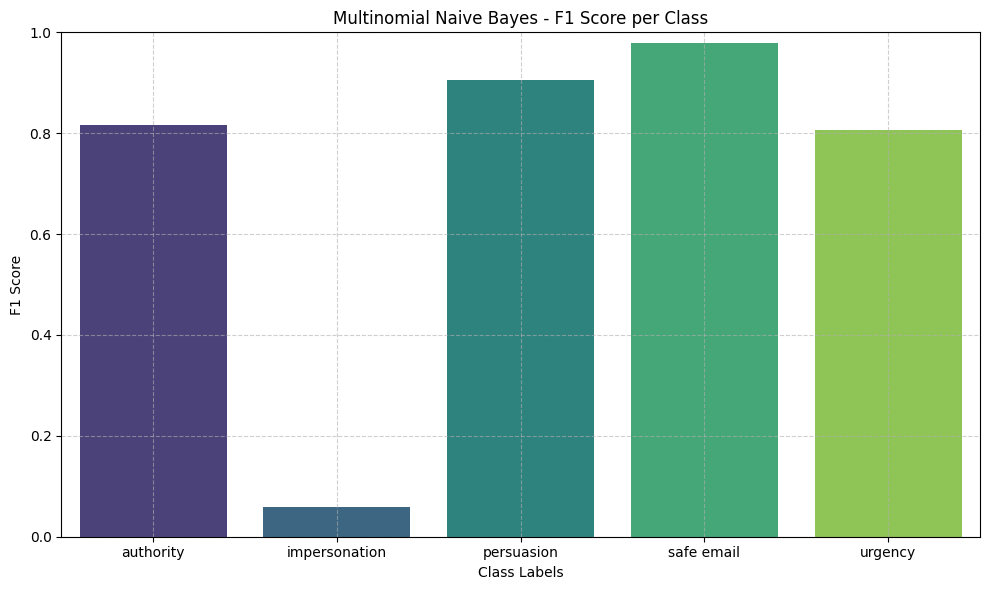

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Calculate F1 scores for each class
f1_scores_nb = f1_score(y_test, y_pred_nb, average=None)

labels = y.columns  # Class labels

# Plot F1 scores per class using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=f1_scores_nb, palette="viridis")
plt.title("Multinomial Naive Bayes - F1 Score per Class")  # Plot title
plt.ylabel("F1 Score")  # Y-axis label
plt.ylim(0, 1)  # Limit y-axis between 0 and 1
plt.xlabel("Class Labels")  # X-axis label
plt.grid(True, linestyle="--", alpha=0.6)  # Add grid with dashed lines and transparency
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

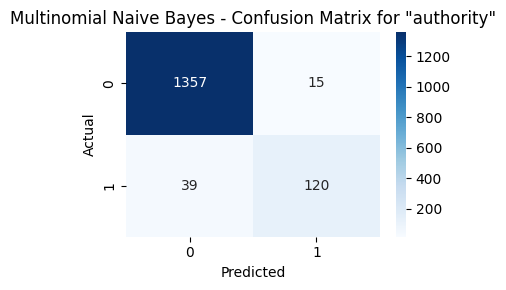

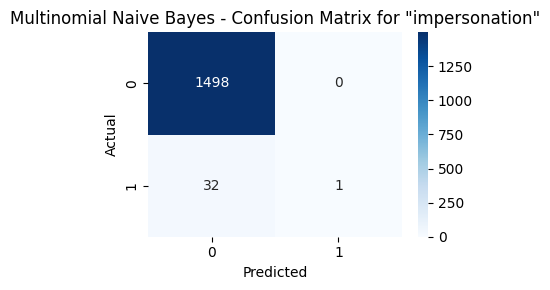

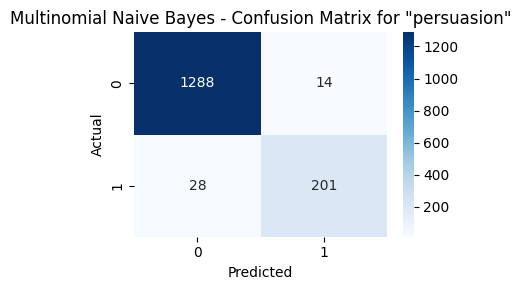

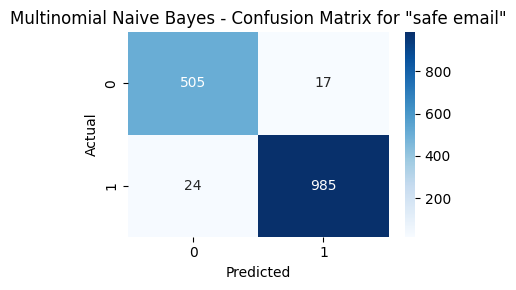

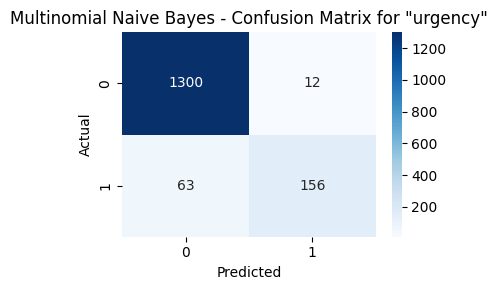

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = y.columns  # Get the list of class labels

# Loop through each label to compute and plot confusion matrix
for idx, label in enumerate(labels):
    # Compute confusion matrix for the current label
    cm = confusion_matrix(y_test[label], y_pred_nb[:, idx])

    plt.figure(figsize=(4, 3))  # Set figure size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Plot heatmap with annotations
    plt.title(f'Multinomial Naive Bayes - Confusion Matrix for "{label}"')  # Title with label name
    plt.xlabel('Predicted')  # X-axis label
    plt.ylabel('Actual')  # Y-axis label
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()  # Display the plot

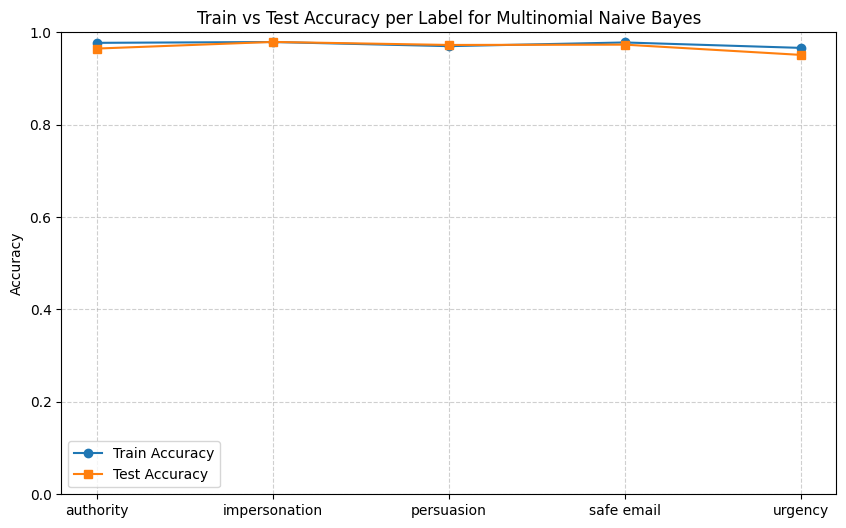

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def plot_accuracy_line(model, X_train, y_train, X_test, y_test, model_name):
    # Predict on training data
    y_train_pred = model.predict(X_train)
    # Predict on test data
    y_test_pred = model.predict(X_test)

    labels = y.columns  # Get the list of class labels
    train_acc = []  # To store training accuracy per label
    test_acc = []   # To store test accuracy per label

    # Calculate accuracy for each label
    for idx, label in enumerate(labels):
        train_acc.append(accuracy_score(y_train[label], y_train_pred[:, idx]))
        test_acc.append(accuracy_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))  # X-axis positions for labels

    plt.figure(figsize=(10,6))
    # Plot training accuracies with circle markers
    plt.plot(x, train_acc, marker='o', label='Train Accuracy')
    # Plot test accuracies with square markers
    plt.plot(x, test_acc, marker='s', label='Test Accuracy')

    plt.xticks(x, labels)  # Set x-axis ticks to label names
    plt.ylim(0,1)          # Accuracy range between 0 and 1
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Test Accuracy per Label for {model_name}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()           # Show legend
    plt.show()             # Display the plot

# Call the function to plot accuracy comparison for Multinomial Naive Bayes model
plot_accuracy_line(nb_model, X_train, y_train, X_test, y_test, "Multinomial Naive Bayes")

# MODEL COMPARISON

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Predictions from different models (assumed to be obtained previously)
# y_pred_logistic, y_pred_svc, y_pred_nb, y_pred_rf (include only models you've trained)

# List of model names
model_names = ['Logistic Regression', 'Multinomial NB', 'Random Forest']

# List of corresponding predictions for each model
all_predictions = [y_pred, y_pred_nb, y_pred_rf]

# Initialize an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Model', 'Label', 'Precision', 'Recall', 'F1', 'Accuracy'])

# Loop through each model and each label to calculate evaluation metrics
for model_name, preds in zip(model_names, all_predictions):
    for idx, label in enumerate(y.columns):
        precision = precision_score(y_test[label], preds[:, idx])
        recall = recall_score(y_test[label], preds[:, idx])
        f1 = f1_score(y_test[label], preds[:, idx])
        accuracy = accuracy_score(y_test[label], preds[:, idx])

        # Append the metrics for current model-label combination to the DataFrame
        metrics_df = pd.concat([metrics_df, pd.DataFrame([{
            'Model': model_name,
            'Label': label,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'Accuracy': accuracy
        }])], ignore_index=True)

# Calculate average metrics per model across all labels
avg_metrics = metrics_df.groupby('Model')[['Precision', 'Recall', 'F1', 'Accuracy']].mean().reset_index()

# Print the average evaluation metrics for each model
print(avg_metrics)

                 Model  Precision    Recall        F1  Accuracy
0  Logistic Regression   0.797129  0.963194  0.863372  0.971783
1       Multinomial NB   0.947076  0.670258  0.713274  0.968125
2        Random Forest   0.988138  0.833338  0.895015  0.984193


<ipython-input-105-1104767132>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


<ipython-input-106-254868897>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=avg_metrics, palette='Set2')
<ipython-input-106-254868897>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=avg_metrics, palette='Set2')
<ipython-input-106-254868897>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=avg_metrics, palette='Set2')
<ipython-input-106-254868897>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

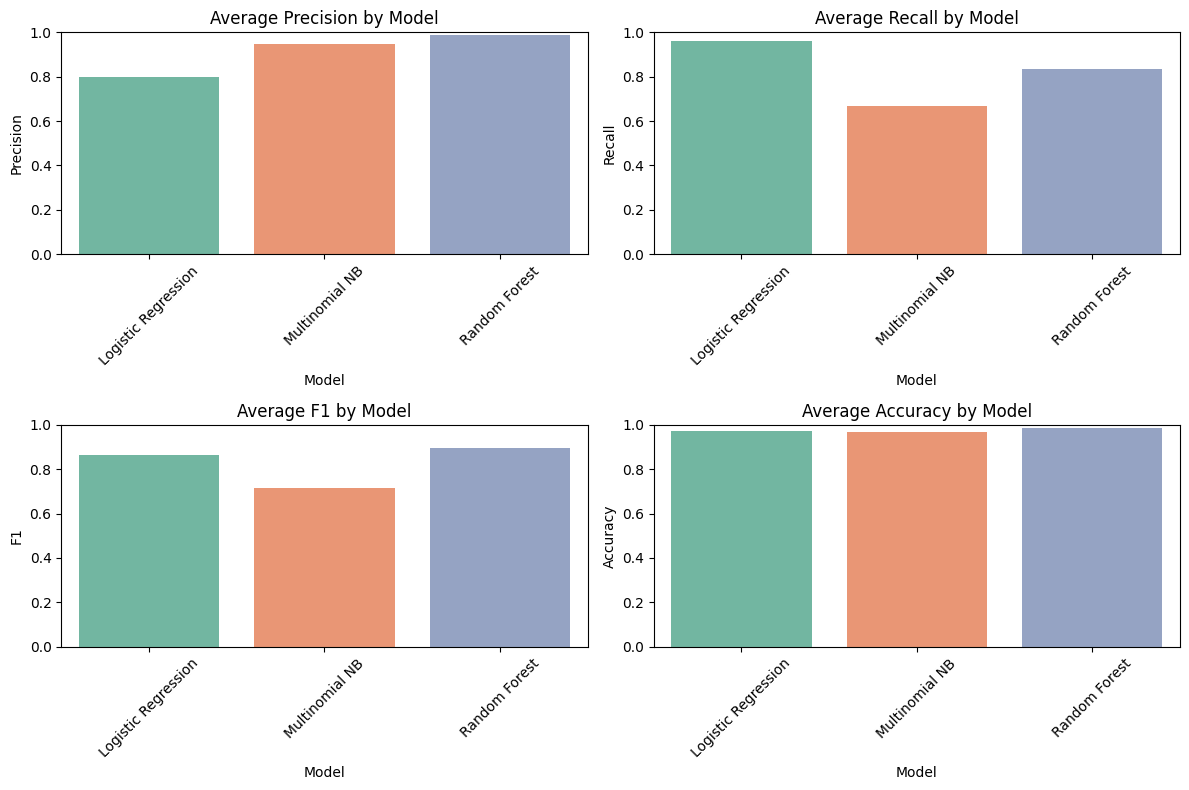

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 8))

# Define the metrics you want to plot
metrics_to_plot = ['Precision', 'Recall', 'F1', 'Accuracy']

# Create a 2x2 subplot for each metric
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)  # Create subplot (2 rows x 2 columns)

    # Plot a barplot for the current metric
    sns.barplot(x='Model', y=metric, data=avg_metrics, palette='Set2')

    # Set plot title and limits
    plt.title(f'Average {metric} by Model')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


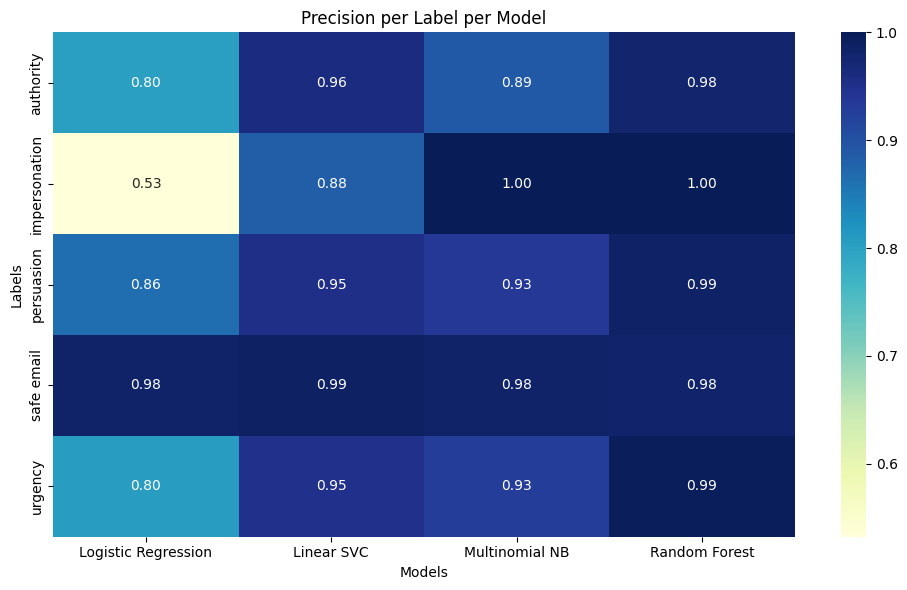

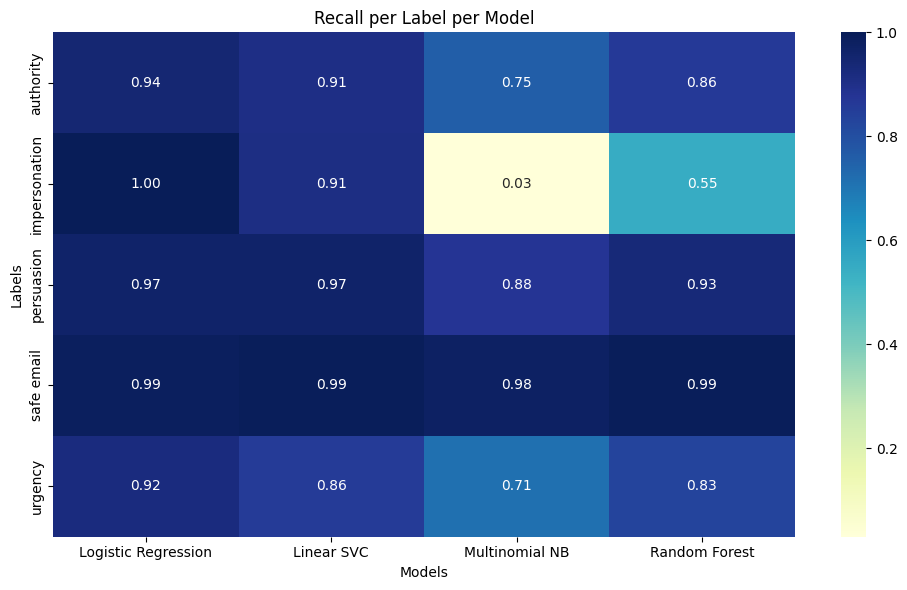

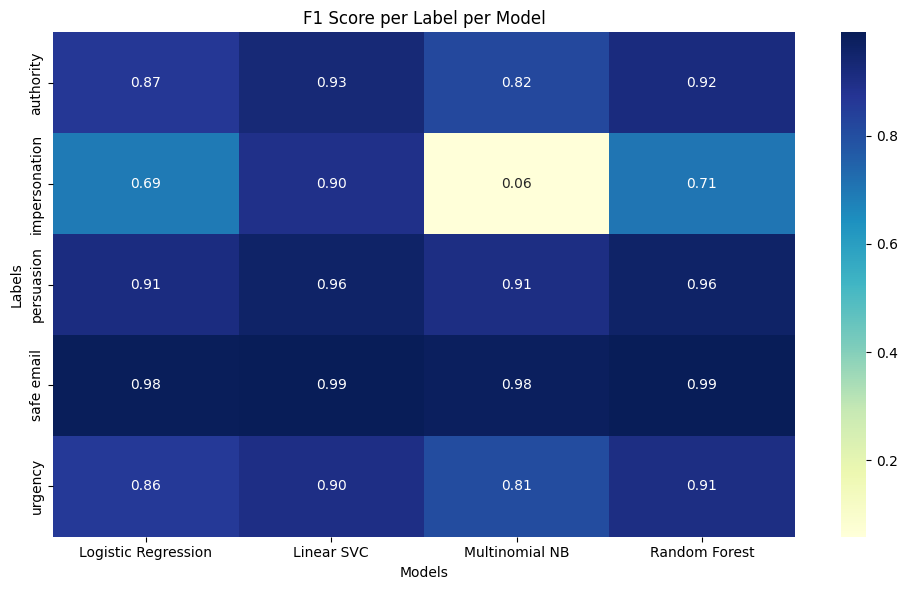

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the model names and their predictions
model_names = ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Random Forest']
all_predictions = [y_pred, y_pred_svc, y_pred_nb, y_pred_rf]

# Create empty dictionaries to store scores
precision_dict = {}
recall_dict = {}
f1_dict = {}

# Loop through each model and calculate metrics per label
for model_name, preds in zip(model_names, all_predictions):
    precisions = []
    recalls = []
    f1s = []
    for idx, label in enumerate(y.columns):
        # Calculate precision, recall, and F1 score for each label
        precisions.append(precision_score(y_test[label], preds[:, idx]))
        recalls.append(recall_score(y_test[label], preds[:, idx]))
        f1s.append(f1_score(y_test[label], preds[:, idx]))
    # Store results in dictionaries
    precision_dict[model_name] = precisions
    recall_dict[model_name] = recalls
    f1_dict[model_name] = f1s

# Convert dictionaries to DataFrames for easier visualization
precision_df = pd.DataFrame(precision_dict, index=y.columns)
recall_df = pd.DataFrame(recall_dict, index=y.columns)
f1_df = pd.DataFrame(f1_dict, index=y.columns)

# Define a function to plot heatmaps for each metric
def plot_heatmap(df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt=".2f")  # Show values with two decimals
    plt.title(title)
    plt.ylabel('Labels')
    plt.xlabel('Models')
    plt.tight_layout()
    plt.show()

# Plot heatmaps for each metric
plot_heatmap(precision_df, 'Precision per Label per Model')
plot_heatmap(recall_df, 'Recall per Label per Model')
plot_heatmap(f1_df, 'F1 Score per Label per Model')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Function to check for overfitting by comparing train and test performance
def check_overfit(model, X_train, y_train, X_test, y_test, model_name):
    # Predictions on the training set
    y_train_pred = model.predict(X_train)

    # Predictions on the test set
    y_test_pred = model.predict(X_test)

    print(f"--- {model_name} ---")

    # Evaluate performance for each label
    for idx, label in enumerate(y.columns):
        # Accuracy and F1 score for train and test sets
        train_acc = accuracy_score(y_train[label], y_train_pred[:, idx])
        test_acc = accuracy_score(y_test[label], y_test_pred[:, idx])
        train_f1 = f1_score(y_train[label], y_train_pred[:, idx])
        test_f1 = f1_score(y_test[label], y_test_pred[:, idx])

        # Print results per label
        print(f"{label}: Train Acc = {train_acc:.3f}, Test Acc = {test_acc:.3f}, "
              f"Train F1 = {train_f1:.3f}, Test F1 = {test_f1:.3f}")
    print("\n")

# Example usage of the function with trained models
check_overfit(model, X_train, y_train, X_test, y_test, "Logistic Regression")
check_overfit(svc_model, X_train, y_train, X_test, y_test, "Linear SVC")
check_overfit(nb_model, X_train, y_train, X_test, y_test, "Multinomial Naive Bayes")
check_overfit(rf_model, X_train, y_train, X_test, y_test, "Random Forest")

--- Logistic Regression ---
authority: Train Acc = 0.986, Test Acc = 0.970, Train F1 = 0.930, Test F1 = 0.867
impersonation: Train Acc = 0.989, Test Acc = 0.981, Train F1 = 0.807, Test F1 = 0.695
persuasion: Train Acc = 0.984, Test Acc = 0.972, Train F1 = 0.947, Test F1 = 0.911
safe email: Train Acc = 0.990, Test Acc = 0.979, Train F1 = 0.992, Test F1 = 0.984
urgency: Train Acc = 0.979, Test Acc = 0.957, Train F1 = 0.919, Test F1 = 0.860


--- Linear SVC ---
authority: Train Acc = 1.000, Test Acc = 0.986, Train F1 = 0.997, Test F1 = 0.932
impersonation: Train Acc = 1.000, Test Acc = 0.995, Train F1 = 0.996, Test F1 = 0.896
persuasion: Train Acc = 0.999, Test Acc = 0.988, Train F1 = 0.995, Test F1 = 0.959
safe email: Train Acc = 0.999, Test Acc = 0.988, Train F1 = 0.999, Test F1 = 0.991
urgency: Train Acc = 0.998, Test Acc = 0.973, Train F1 = 0.992, Test F1 = 0.902


--- Multinomial Naive Bayes ---
authority: Train Acc = 0.977, Test Acc = 0.965, Train F1 = 0.870, Test F1 = 0.816
imperso

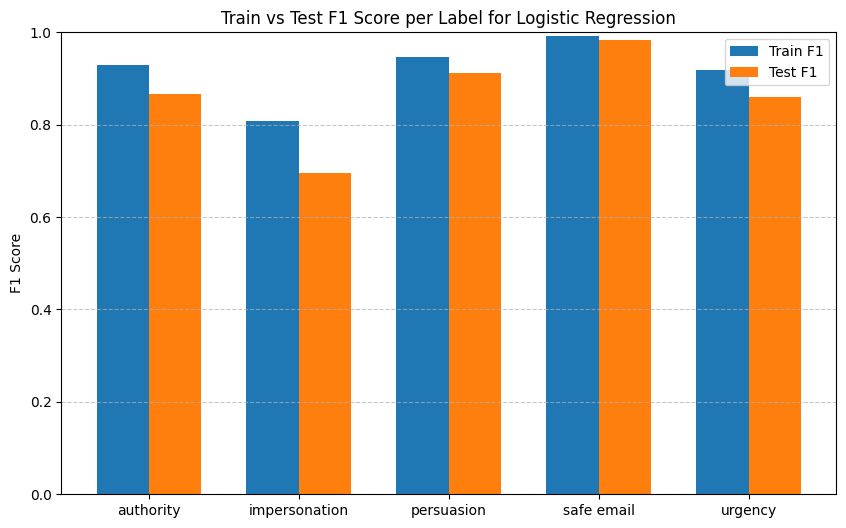

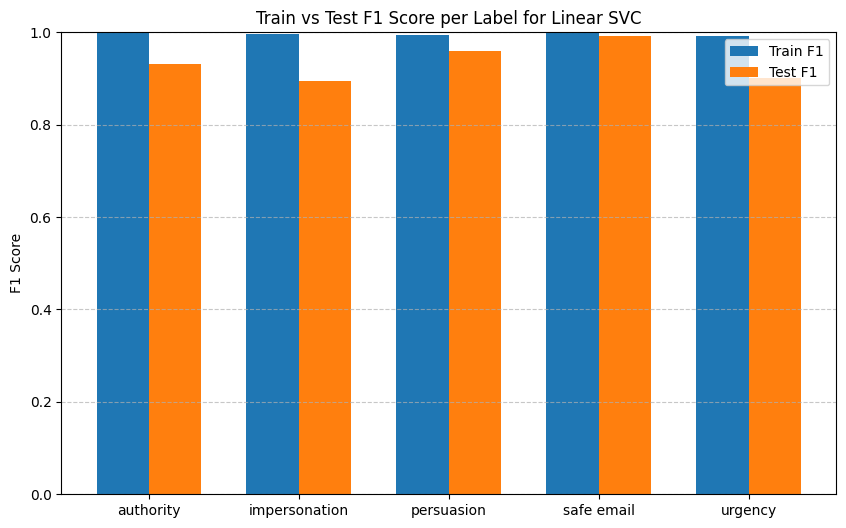

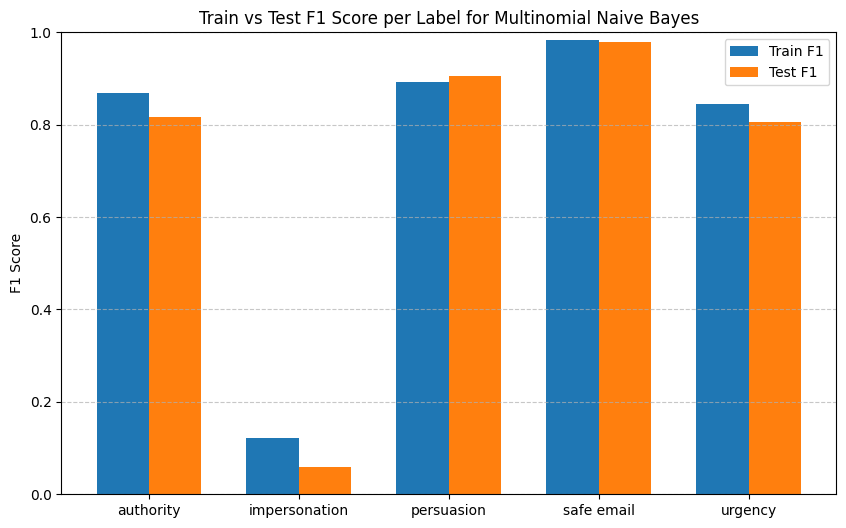

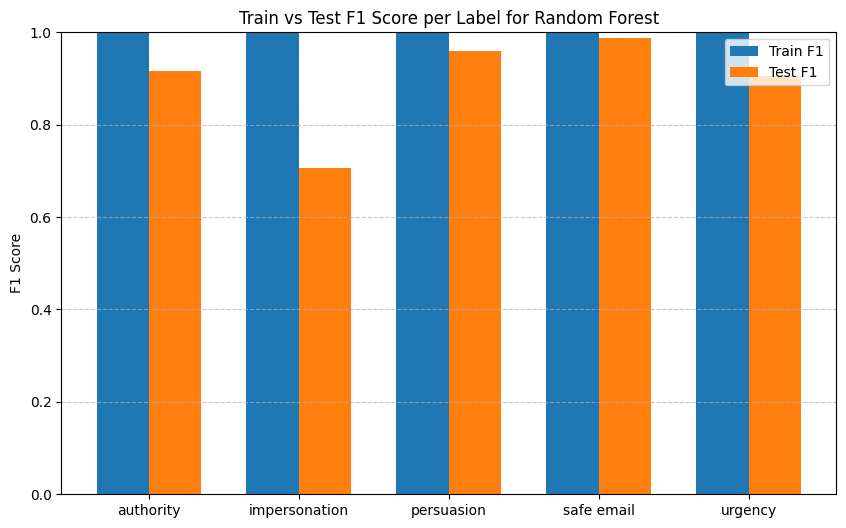

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Function to plot bar chart of Train vs Test F1 scores for each label
def plot_overfit_bar(model, X_train, y_train, X_test, y_test, model_name):
    # Predict on training data
    y_train_pred = model.predict(X_train)
    # Predict on test data
    y_test_pred = model.predict(X_test)

    labels = y.columns
    train_f1 = []
    test_f1 = []

    # Calculate F1 scores for each label
    for idx, label in enumerate(labels):
        train_f1.append(f1_score(y_train[label], y_train_pred[:, idx]))
        test_f1.append(f1_score(y_test[label], y_test_pred[:, idx]))

    x = np.arange(len(labels))  # label indices for x-axis
    width = 0.35  # bar width

    # Create bar chart
    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, train_f1, width, label='Train F1')  # Bar for train F1
    plt.bar(x + width/2, test_f1, width, label='Test F1')    # Bar for test F1

    plt.xticks(x, labels)         # Label names on x-axis
    plt.ylim(0,1)                 # Y-axis limit for F1 score range
    plt.ylabel('F1 Score')
    plt.title(f'Train vs Test F1 Score per Label for {model_name}')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Light grid lines
    plt.show()

# Example usage for all models
plot_overfit_bar(model, X_train, y_train, X_test, y_test, "Logistic Regression")
plot_overfit_bar(svc_model, X_train, y_train, X_test, y_test, "Linear SVC")
plot_overfit_bar(nb_model, X_train, y_train, X_test, y_test, "Multinomial Naive Bayes")
plot_overfit_bar(rf_model, X_train, y_train, X_test, y_test, "Random Forest")

**PRECISION-RECALL CURVES FOR TRAINED MODELS**

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Function to plot precision-recall curves for each label
def plot_precision_recall_curves(y_true, y_scores, model_name, label_names):
    """
    Plots the precision-recall curve for each class in a multi-label classification problem.

    Parameters:
    - y_true: DataFrame or 2D array with true binary labels
    - y_scores: 2D array with predicted probabilities or decision function scores
    - model_name: string, name of the model (used in the title)
    - label_names: list of label names
    """
    plt.figure(figsize=(12, 8))

    for i in range(len(label_names)):
        # Compute precision-recall curve
        precision, recall, _ = precision_recall_curve(y_true.iloc[:, i], y_scores[:, i])
        # Calculate average precision score
        ap_score = average_precision_score(y_true.iloc[:, i], y_scores[:, i])

        # Plot curve for each label
        plt.plot(recall, precision, label=f"{label_names[i]} (AP={ap_score:.2f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for {model_name}')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



PRECISION-RECALL CURVES FOR LOGISTIC REGRESSION

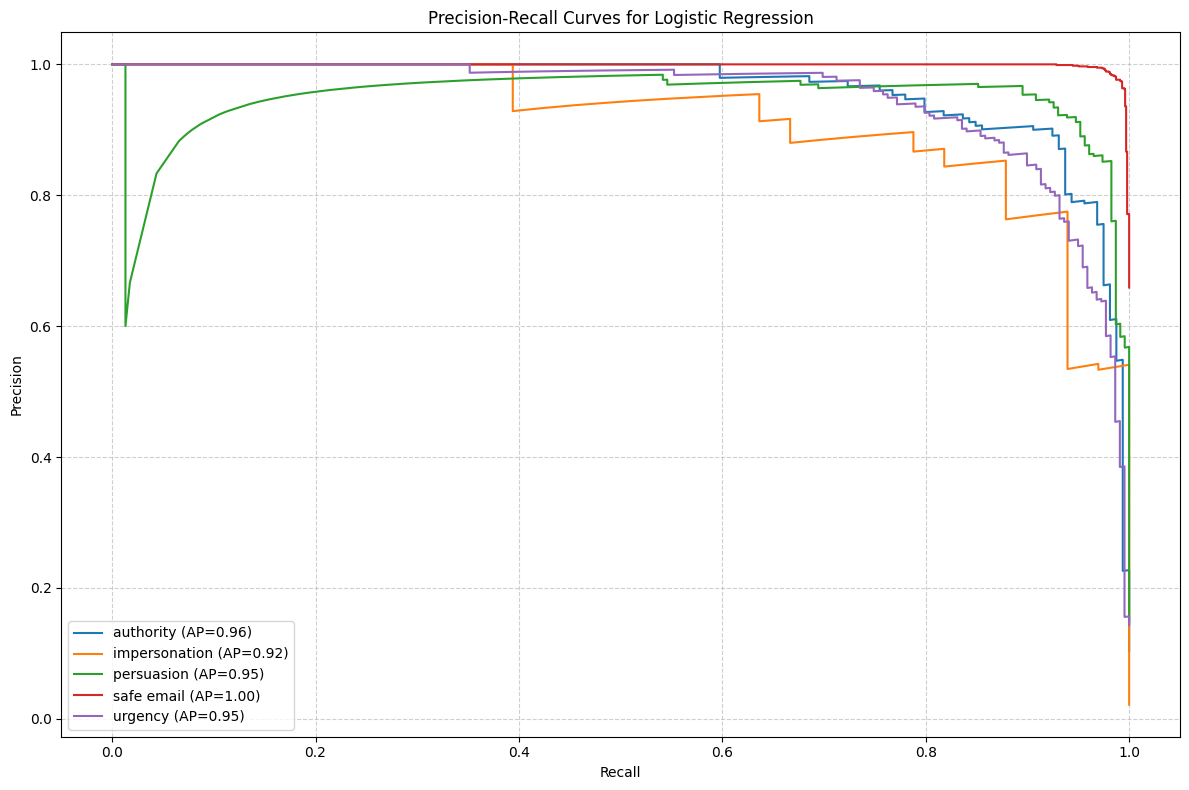

In [ ]:
# Olasılık tahminlerini al
y_pred_proba = model.predict_proba(X_test)

# predict_proba() çıktısı bir liste (her sınıf için olasılıklar)
# OneVsRestClassifier ile çalışıyorsan bu şekilde düzenleyebilirsin:
y_pred_proba = np.asarray([estimator.predict_proba(X_test)[:, 1] for estimator in model.estimators_]).T

# PR eğrisi çiz
plot_precision_recall_curves(y_test, y_pred_proba, "Logistic Regression", y.columns)


PRECISION-RECALL CURVES FOR LINEAR SUPPORT VECTOR CLASSIFIER

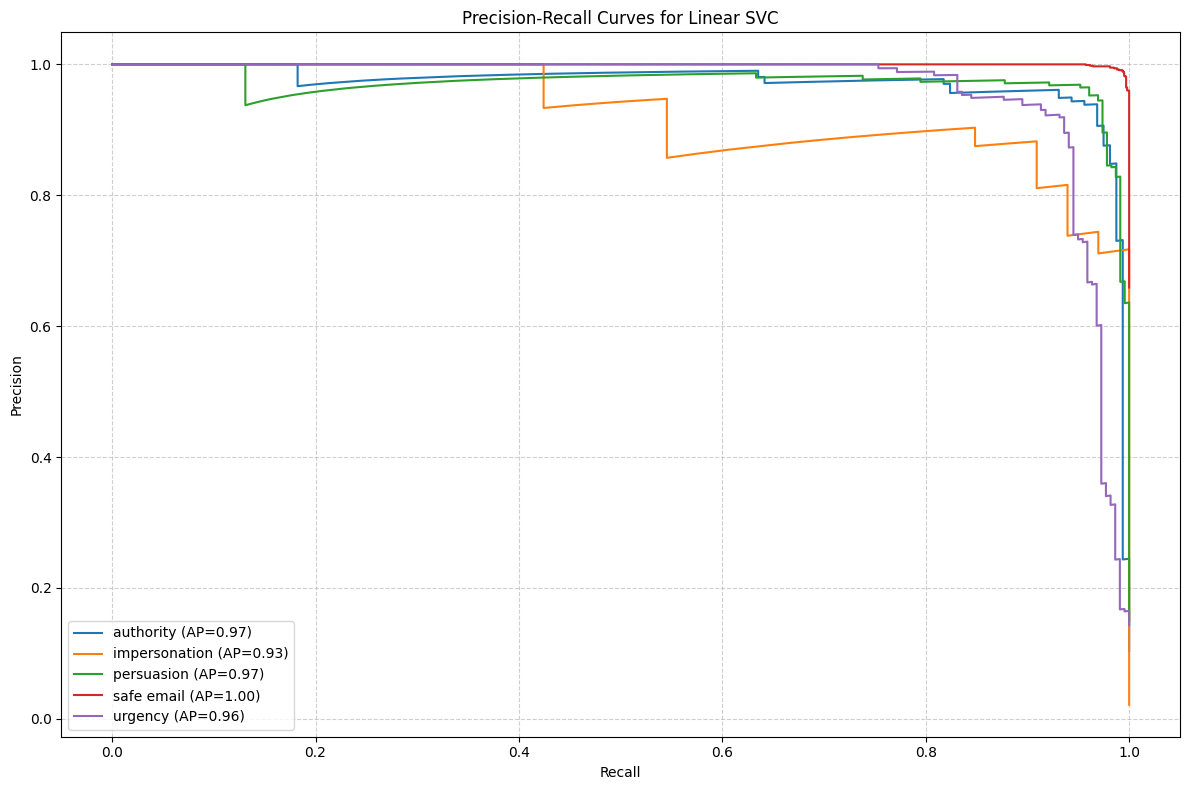

In [ ]:
# SVC için decision function kullanılır (raw scores)
y_scores_svc = np.asarray([estimator.decision_function(X_test) for estimator in svc_model.estimators_]).T

# PR eğrisi çiz
plot_precision_recall_curves(y_test, y_scores_svc, "Linear SVC", y.columns)

PRECISION-RECALL CURVES FOR MULTINOMIAL NAIVE BAYES

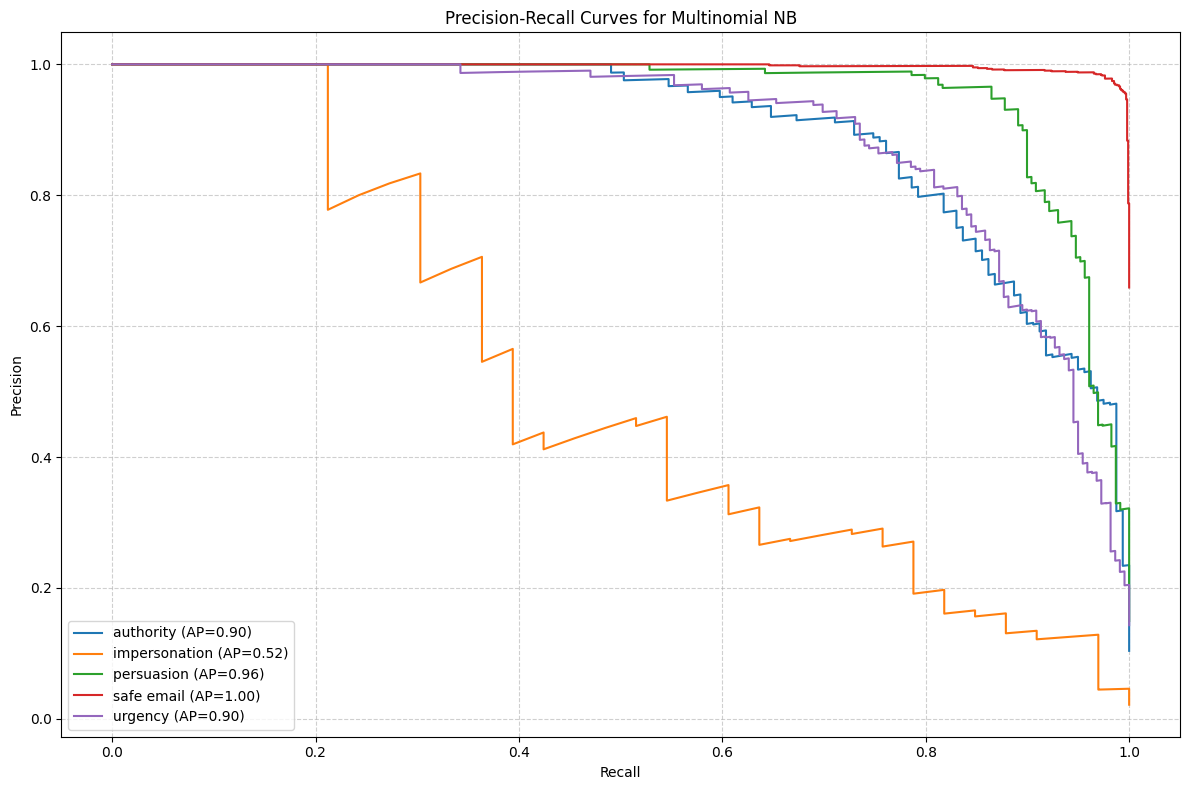

In [ ]:
# Naive Bayes predict_proba destekler
y_pred_proba_nb = np.asarray([estimator.predict_proba(X_test)[:, 1] for estimator in nb_model.estimators_]).T

# PR eğrisi çiz
plot_precision_recall_curves(y_test, y_pred_proba_nb, "Multinomial NB", y.columns)

PRECISION-RECALL CURVES FOR RANDOM FOREST

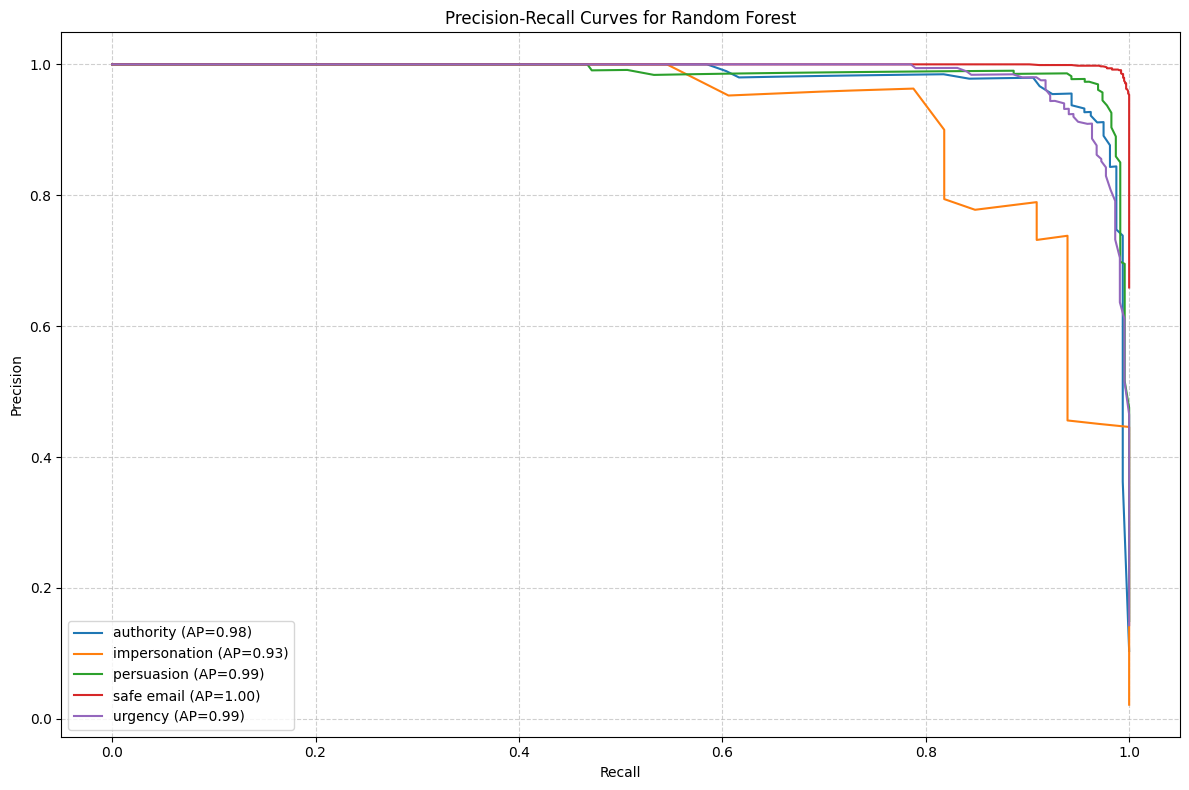

In [ ]:
# Random Forest da predict_proba destekler
y_pred_proba_rf = np.asarray([estimator.predict_proba(X_test)[:, 1] for estimator in rf_model.estimators_]).T

# PR eğrisi çiz
plot_precision_recall_curves(y_test, y_pred_proba_rf, "Random Forest", y.columns)


# REFERENCES



*   https://chatgpt.com/
*   https://gemini.google.com/
*   https://www.kaggle.com/datasets/subhajournal/phishingemails
*   https://www.kaggle.com/datasets/akileshga/email-phishing-legitimate-classifier
*   https://www.kaggle.com/datasets/ahmadtijjani/phishing-urgency-authority-persuasion
*   https://www.kaggle.com/code/kirollosashraf/phishing-email-detection-using-deep-learning
*   https://www.kaggle.com/code/horpynichelizaveta/naive-bayes-classifier



